# Reddit Sentiment Analysis - Experiment 4: Neural Networks with Embeddings

This notebook implements neural network models (RNN, GRU, LSTM) with word embeddings
for sentiment analysis on the balanced Reddit comments dataset.

## Table of Contents
1. Setup and Dependencies
2. Data Loading and Preprocessing
3. Neural Network Models Implementation
4. Training and Evaluation Framework
5. MLflow Experiment Tracking

In [ ]:
pip install mlflow

# 1. Setup and Dependencies

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import joblib
import warnings
warnings.filterwarnings('ignore')

# MLflow imports
import mlflow
import mlflow.pytorch

# Sklearn imports for evaluation
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                           f1_score, balanced_accuracy_score, matthews_corrcoef,
                           cohen_kappa_score, precision_recall_fscore_support)
from sklearn.preprocessing import LabelEncoder
from collections import Counter

In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [6]:
# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

In [7]:
# Mount Google Drive for MLflow
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Data Loading and Preprocessing

In [8]:
print("Loading balanced dataset...")
df = pd.read_pickle("balanced_reddit_df.pkl")

# Use the balanced data
texts = df['clean_comment'].astype(str).tolist()
labels = df['category'].tolist()

print(f"Dataset size: {len(texts)}")
print(f"Unique labels: {sorted(set(labels))}")

Loading balanced dataset...
Dataset size: 36662
Unique labels: [-1, 0, 1]


In [9]:
# Check class distribution
class_dist = pd.Series(labels).value_counts().sort_index()
print("\nClass distribution:")
for label, count in class_dist.items():
    print(f"  Class {label}: {count} samples")


Class distribution:
  Class -1: 8248 samples
  Class 0: 12644 samples
  Class 1: 15770 samples


In [10]:
# Encode labels to start from 0 (required for CrossEntropy)
label_mapping = {-1: 0, 0: 1, 1: 2}  # Negative->0, Neutral->1, Positive->2
labels_encoded = [label_mapping[label] for label in labels]

print(f"\nLabel mapping: {label_mapping}")
print(f"Encoded labels range: {min(labels_encoded)} to {max(labels_encoded)}")


Label mapping: {-1: 0, 0: 1, 1: 2}
Encoded labels range: 0 to 2


In [11]:
# Simple tokenization function
def simple_tokenize(text):
    """Simple tokenization - split by spaces and convert to lowercase"""
    return text.lower().split()

# Build vocabulary from training data
print("\nBuilding vocabulary...")
vocab_counter = Counter()
for text in texts:
    tokens = simple_tokenize(text)
    vocab_counter.update(tokens)


Building vocabulary...


In [12]:
# Create vocabulary (keep most common words)
vocab_size = 15000
most_common = vocab_counter.most_common(vocab_size - 2)  # -2 for PAD and UNK

vocab = {'<PAD>': 0, '<UNK>': 1}
for word, _ in most_common:
    vocab[word] = len(vocab)

print(f"Vocabulary size: {len(vocab)}")

Vocabulary size: 15000


In [13]:
# Text to indices conversion
def text_to_indices(text, vocab, max_length=128):
    """Convert text to indices with padding/truncation"""
    tokens = simple_tokenize(text)
    indices = [vocab.get(token, vocab['<UNK>']) for token in tokens]

    # Truncate or pad
    if len(indices) > max_length:
        indices = indices[:max_length]
    else:
        indices = indices + [vocab['<PAD>']] * (max_length - len(indices))

    return indices

# Convert all texts to indices
max_seq_length = 128
print(f"Converting texts to indices (max length: {max_seq_length})...")
X_indices = [text_to_indices(text, vocab, max_seq_length) for text in texts]
y = labels_encoded

Converting texts to indices (max length: 128)...


In [14]:
# Train/validation/test split
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(
    X_indices, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

Train size: 23463
Validation size: 5866
Test size: 7333


# 3. Neural Network Models Implementation

In [16]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.tensor(texts, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, rnn_type='LSTM', dropout=0.3):
        super(SentimentRNN, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        if rnn_type == 'RNN':
            self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True, dropout=dropout)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(embed_dim, hidden_dim, batch_first=True, dropout=dropout)
        elif rnn_type == 'LSTM':
            self.rnn = nn.LSTM(embed_dim, hidden_dim, batch_first=True, dropout=dropout)

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # x shape: (batch_size, seq_len)
        embedded = self.embedding(x)  # (batch_size, seq_len, embed_dim)

        # RNN forward pass
        output, hidden = self.rnn(embedded)  # output: (batch_size, seq_len, hidden_dim)

        # Take the last output (for sentiment classification)
        last_output = output[:, -1, :]  # (batch_size, hidden_dim)

        # Apply dropout and classification layer
        dropped = self.dropout(last_output)
        logits = self.fc(dropped)  # (batch_size, num_classes)

        return logits

In [17]:
def train_model(model, train_loader, val_loader, num_epochs=10, lr=0.001):
    """Train the model and return training history"""

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []
    val_accuracies = []

    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0

        for batch_texts, batch_labels in train_loader:
            batch_texts, batch_labels = batch_texts.to(device), batch_labels.to(device)

            optimizer.zero_grad()
            outputs = model(batch_texts)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch_texts, batch_labels in val_loader:
                batch_texts, batch_labels = batch_texts.to(device), batch_labels.to(device)

                outputs = model(batch_texts)
                loss = criterion(outputs, batch_labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                val_total += batch_labels.size(0)
                val_correct += (predicted == batch_labels).sum().item()

        # Calculate averages
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        val_accuracy = val_correct / val_total

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Val Loss: {val_loss:.4f}")
        print(f"  Val Accuracy: {val_accuracy:.4f}")

    # Load best model
    model.load_state_dict(best_model_state)

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'best_val_loss': best_val_loss
    }

def evaluate_model(model, test_loader):
    """Comprehensive model evaluation"""

    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for batch_texts, batch_labels in test_loader:
            batch_texts, batch_labels = batch_texts.to(device), batch_labels.to(device)

            outputs = model(batch_texts)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    balanced_accuracy = balanced_accuracy_score(all_labels, all_predictions)
    f1_macro = f1_score(all_labels, all_predictions, average='macro')
    f1_weighted = f1_score(all_labels, all_predictions, average='weighted')
    matthews_corr = matthews_corrcoef(all_labels, all_predictions)
    cohen_kappa = cohen_kappa_score(all_labels, all_predictions)

    # Per-class metrics
    precision, recall, f1_per_class, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average=None
    )

    # Classification report
    class_names = ['Negative', 'Neutral', 'Positive']
    class_report = classification_report(
        all_labels, all_predictions,
        target_names=class_names,
        output_dict=True
    )

    # Confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    return {
        'accuracy': accuracy,
        'balanced_accuracy': balanced_accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'matthews_corrcoef': matthews_corr,
        'cohen_kappa': cohen_kappa,
        'precision_per_class': precision,
        'recall_per_class': recall,
        'f1_per_class': f1_per_class,
        'classification_report': class_report,
        'confusion_matrix': conf_matrix,
        'predictions': all_predictions,
        'labels': all_labels,
        'probabilities': all_probabilities
    }

def plot_training_history(history, title="Training History"):
    """Plot training and validation metrics"""

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss plot
    epochs = range(1, len(history['train_losses']) + 1)
    ax1.plot(epochs, history['train_losses'], 'b-', label='Training Loss')
    ax1.plot(epochs, history['val_losses'], 'r-', label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy plot
    ax2.plot(epochs, history['val_accuracies'], 'g-', label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()

    return fig

def plot_confusion_matrix(conf_matrix, class_names, title="Confusion Matrix"):
    """Plot confusion matrix"""

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title, fontweight='bold')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()

    return plt

def plot_metrics_comparison(results_list, experiment_names):
    """Plot comparison of different experiments"""

    metrics = ['accuracy', 'balanced_accuracy', 'f1_macro', 'f1_weighted', 'matthews_corrcoef']
    metric_names = ['Accuracy', 'Balanced Accuracy', 'F1 Macro', 'F1 Weighted', 'Matthews Corr']

    fig, ax = plt.subplots(figsize=(12, 6))

    x = np.arange(len(metrics))
    width = 0.25

    for i, (results, name) in enumerate(zip(results_list, experiment_names)):
        values = [results[metric] for metric in metrics]
        ax.bar(x + i * width, values, width, label=name, alpha=0.8)

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Score')
    ax.set_title('Model Performance Comparison')
    ax.set_xticks(x + width)
    ax.set_xticklabels(metric_names, rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

# 4. Experiment Configuration and Execution

In [18]:
# Setup MLflow
mlflow.set_tracking_uri("file:///content/drive/MyDrive/mlflow_logs")
experiment_name = "Neural_Network_Sentiment_Analysis"
mlflow.set_experiment(experiment_name)
print(f"✓ MLflow experiment set: {experiment_name}")

# Experiment configurations
rnn_types = ['RNN', 'GRU', 'LSTM']
embed_dims = [64, 128, 256]
hidden_dim = 128
num_classes = 3
batch_size = 64
num_epochs = 15
learning_rate = 0.001

2025/08/01 20:45:45 INFO mlflow.tracking.fluent: Experiment with name 'Neural_Network_Sentiment_Analysis' does not exist. Creating a new experiment.


✓ MLflow experiment set: Neural_Network_Sentiment_Analysis


In [19]:
from mlflow.tracking import MlflowClient

client = MlflowClient(tracking_uri="file:///content/drive/MyDrive/mlflow_logs")
experiments = client.search_experiments()

for exp in experiments:
    print(f"Name: {exp.name} | ID: {exp.experiment_id} | Artifact Location: {exp.artifact_location}")

Name: Neural_Network_Sentiment_Analysis | ID: 860794644769138398 | Artifact Location: file:///content/drive/MyDrive/mlflow_logs/860794644769138398
Name: Enhanced_Sentiment_Analysis_with_Balancing | ID: 957923626761089126 | Artifact Location: file:///content/drive/MyDrive/mlflow_logs/957923626761089126
Name: Reddit_Sentiment_Baseline | ID: 300921718200322684 | Artifact Location: file:///content/drive/MyDrive/mlflow_logs/300921718200322684
Name: BoW_vs_TfIdf_Comparison | ID: 147337520425050598 | Artifact Location: file:///content/drive/MyDrive/mlflow_logs/147337520425050598
Name: Default | ID: 0 | Artifact Location: file:///content/drive/MyDrive/mlflow_logs/0


In [20]:
# Create data loaders
train_dataset = SentimentDataset(X_train, y_train)
val_dataset = SentimentDataset(X_val, y_val)
test_dataset = SentimentDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Data loaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

Data loaders created:
  Train batches: 367
  Val batches: 92
  Test batches: 115



Starting 9 experiments...

EXPERIMENT 1/9
RNN Type: RNN | Embedding Dim: 64
--------------------------------------------------
Model created with 985219 parameters
Training...
Epoch 1/15
  Train Loss: 1.0685
  Val Loss: 1.0667
  Val Accuracy: 0.4265
Epoch 2/15
  Train Loss: 1.0633
  Val Loss: 1.0687
  Val Accuracy: 0.4250
Epoch 3/15
  Train Loss: 1.0731
  Val Loss: 1.0696
  Val Accuracy: 0.4274
Epoch 4/15
  Train Loss: 1.0812
  Val Loss: 1.0718
  Val Accuracy: 0.4136
Epoch 5/15
  Train Loss: 1.0749
  Val Loss: 1.0747
  Val Accuracy: 0.3991
Epoch 6/15
  Train Loss: 1.0727
  Val Loss: 1.0692
  Val Accuracy: 0.4115
Epoch 7/15
  Train Loss: 1.0707
  Val Loss: 1.0707
  Val Accuracy: 0.4284
Epoch 8/15
  Train Loss: 1.0717
  Val Loss: 1.0689
  Val Accuracy: 0.4301
Epoch 9/15
  Train Loss: 1.0714
  Val Loss: 1.0698
  Val Accuracy: 0.4286
Epoch 10/15
  Train Loss: 1.0700
  Val Loss: 1.0727
  Val Accuracy: 0.4199
Epoch 11/15
  Train Loss: 1.0682
  Val Loss: 1.0709
  Val Accuracy: 0.4200
Epoch 1

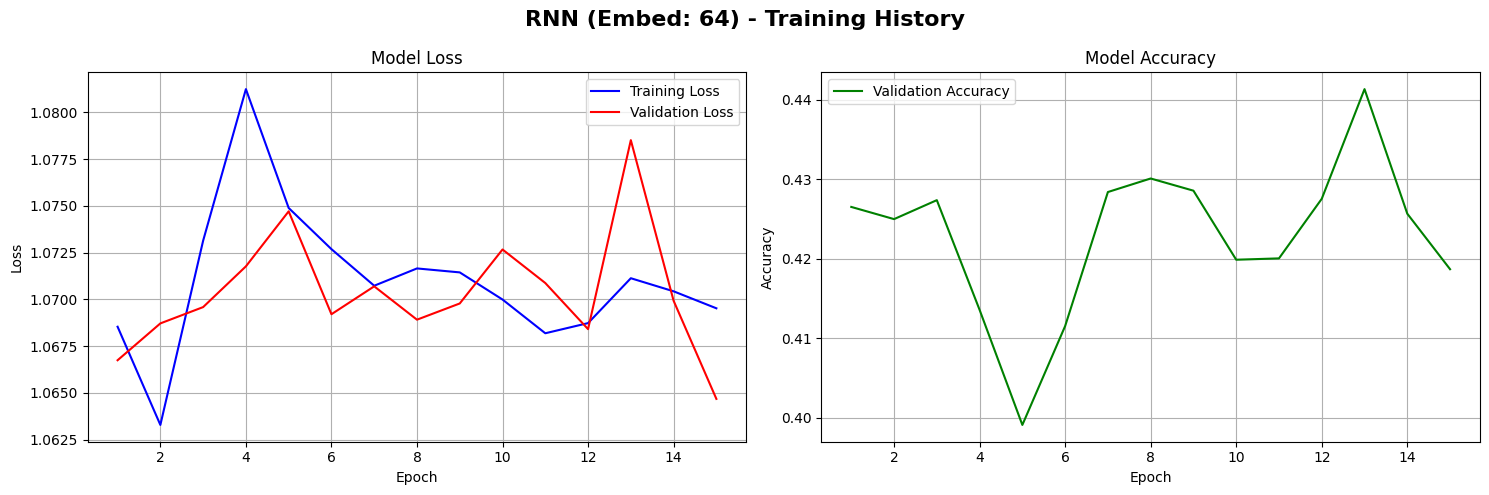

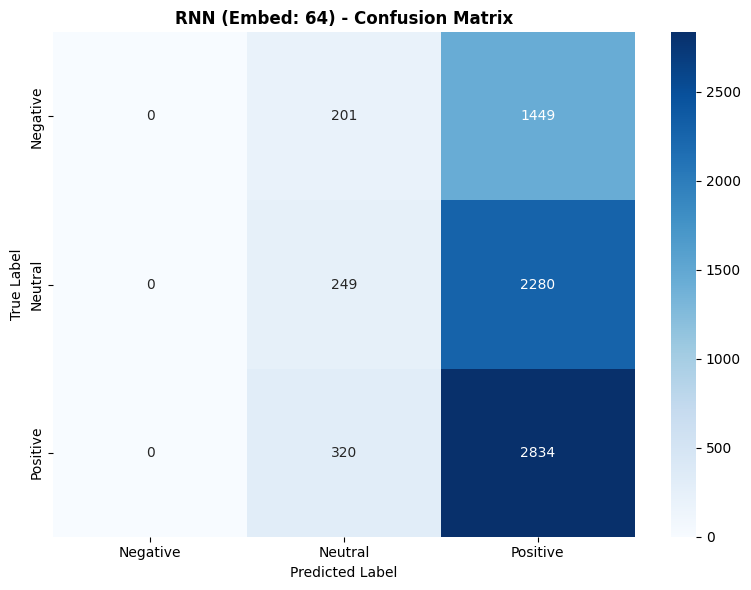

✓ Experiment completed successfully!
  Accuracy: 0.4204
  Balanced Accuracy: 0.3323
  F1-Score (Macro): 0.2448

EXPERIMENT 2/9
RNN Type: RNN | Embedding Dim: 128
--------------------------------------------------
Model created with 1953411 parameters
Training...
Epoch 1/15
  Train Loss: 1.0684
  Val Loss: 1.0695
  Val Accuracy: 0.4260
Epoch 2/15
  Train Loss: 1.0843
  Val Loss: 1.0688
  Val Accuracy: 0.4275
Epoch 3/15
  Train Loss: 1.0776
  Val Loss: 1.0674
  Val Accuracy: 0.4286
Epoch 4/15
  Train Loss: 1.0746
  Val Loss: 1.0659
  Val Accuracy: 0.4286
Epoch 5/15
  Train Loss: 1.0710
  Val Loss: 1.0660
  Val Accuracy: 0.4332
Epoch 6/15
  Train Loss: 1.0703
  Val Loss: 1.0675
  Val Accuracy: 0.4320
Epoch 7/15
  Train Loss: 1.0663
  Val Loss: 1.0683
  Val Accuracy: 0.4228
Epoch 8/15
  Train Loss: 1.0697
  Val Loss: 1.0675
  Val Accuracy: 0.4371
Epoch 9/15
  Train Loss: 1.0703
  Val Loss: 1.0741
  Val Accuracy: 0.4144
Epoch 10/15
  Train Loss: 1.0695
  Val Loss: 1.0652
  Val Accuracy: 0.4

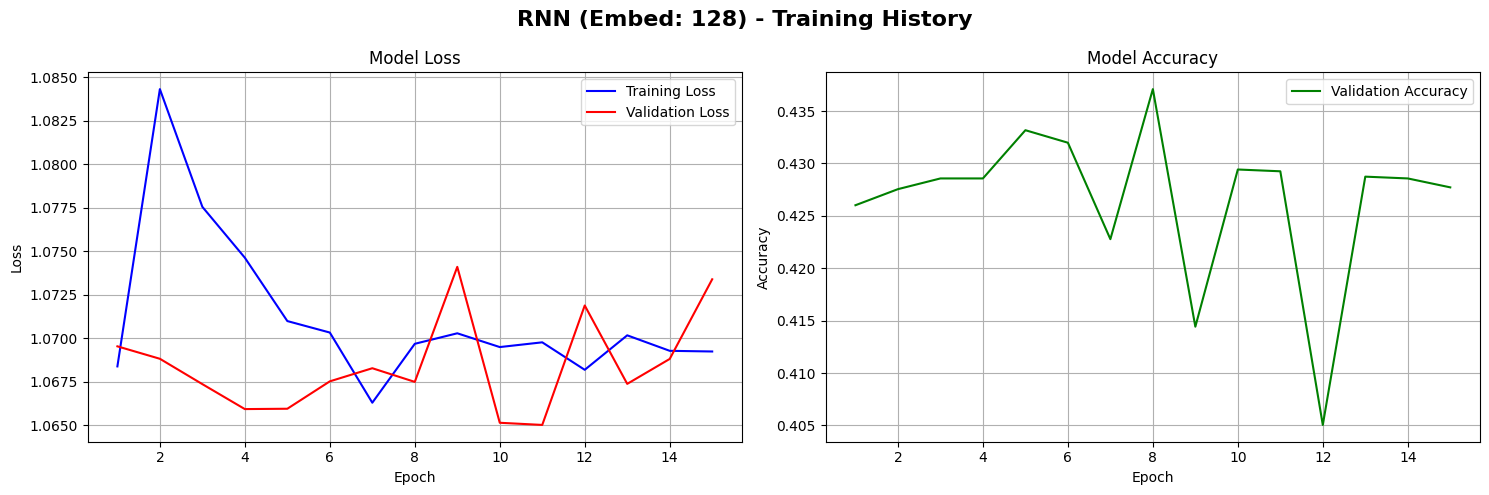

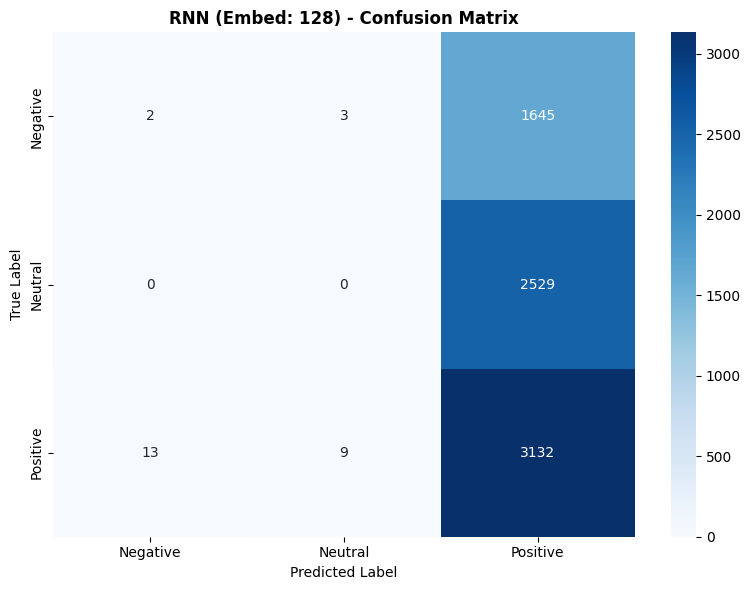

✓ Experiment completed successfully!
  Accuracy: 0.4274
  Balanced Accuracy: 0.3314
  F1-Score (Macro): 0.2004

EXPERIMENT 3/9
RNN Type: RNN | Embedding Dim: 256
--------------------------------------------------
Model created with 3889795 parameters
Training...
Epoch 1/15
  Train Loss: 1.0692
  Val Loss: 1.0671
  Val Accuracy: 0.4258
Epoch 2/15
  Train Loss: 1.0633
  Val Loss: 1.0680
  Val Accuracy: 0.4252
Epoch 3/15
  Train Loss: 1.0543
  Val Loss: 1.0699
  Val Accuracy: 0.4250
Epoch 4/15
  Train Loss: 1.0500
  Val Loss: 1.0719
  Val Accuracy: 0.4253
Epoch 5/15
  Train Loss: 1.0481
  Val Loss: 1.0745
  Val Accuracy: 0.4260
Epoch 6/15
  Train Loss: 1.0472
  Val Loss: 1.0766
  Val Accuracy: 0.4247
Epoch 7/15
  Train Loss: 1.0540
  Val Loss: 1.0762
  Val Accuracy: 0.4238
Epoch 8/15
  Train Loss: 1.0594
  Val Loss: 1.0711
  Val Accuracy: 0.4240
Epoch 9/15
  Train Loss: 1.0492
  Val Loss: 1.0730
  Val Accuracy: 0.4255
Epoch 10/15
  Train Loss: 1.0475
  Val Loss: 1.0757
  Val Accuracy: 0.4

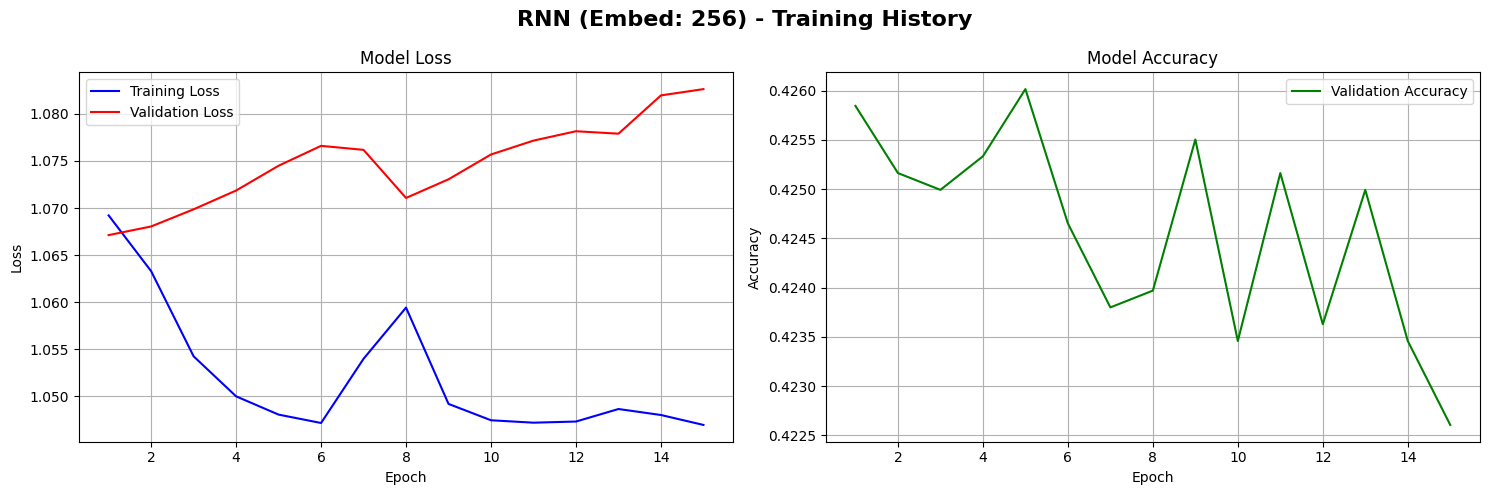

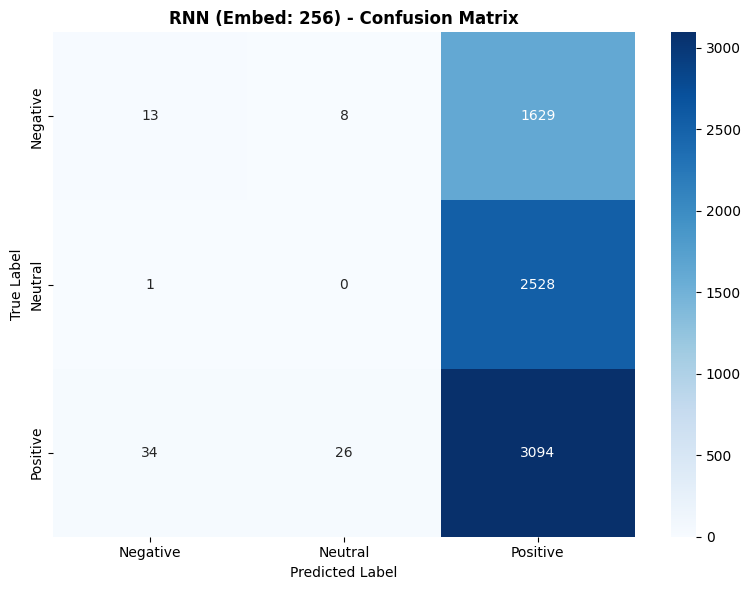

✓ Experiment completed successfully!
  Accuracy: 0.4237
  Balanced Accuracy: 0.3296
  F1-Score (Macro): 0.2033

EXPERIMENT 4/9
RNN Type: GRU | Embedding Dim: 64
--------------------------------------------------
Model created with 1034883 parameters
Training...
Epoch 1/15
  Train Loss: 1.0643
  Val Loss: 1.0457
  Val Accuracy: 0.4301
Epoch 2/15
  Train Loss: 0.8830
  Val Loss: 0.7840
  Val Accuracy: 0.6517
Epoch 3/15
  Train Loss: 0.6854
  Val Loss: 0.6521
  Val Accuracy: 0.7283
Epoch 4/15
  Train Loss: 0.5350
  Val Loss: 0.5716
  Val Accuracy: 0.7728
Epoch 5/15
  Train Loss: 0.4103
  Val Loss: 0.5456
  Val Accuracy: 0.8005
Epoch 6/15
  Train Loss: 0.3102
  Val Loss: 0.5681
  Val Accuracy: 0.8023
Epoch 7/15
  Train Loss: 0.2311
  Val Loss: 0.6015
  Val Accuracy: 0.8069
Epoch 8/15
  Train Loss: 0.1696
  Val Loss: 0.6330
  Val Accuracy: 0.8089
Epoch 9/15
  Train Loss: 0.1267
  Val Loss: 0.6961
  Val Accuracy: 0.8062
Epoch 10/15
  Train Loss: 0.1020
  Val Loss: 0.7401
  Val Accuracy: 0.80

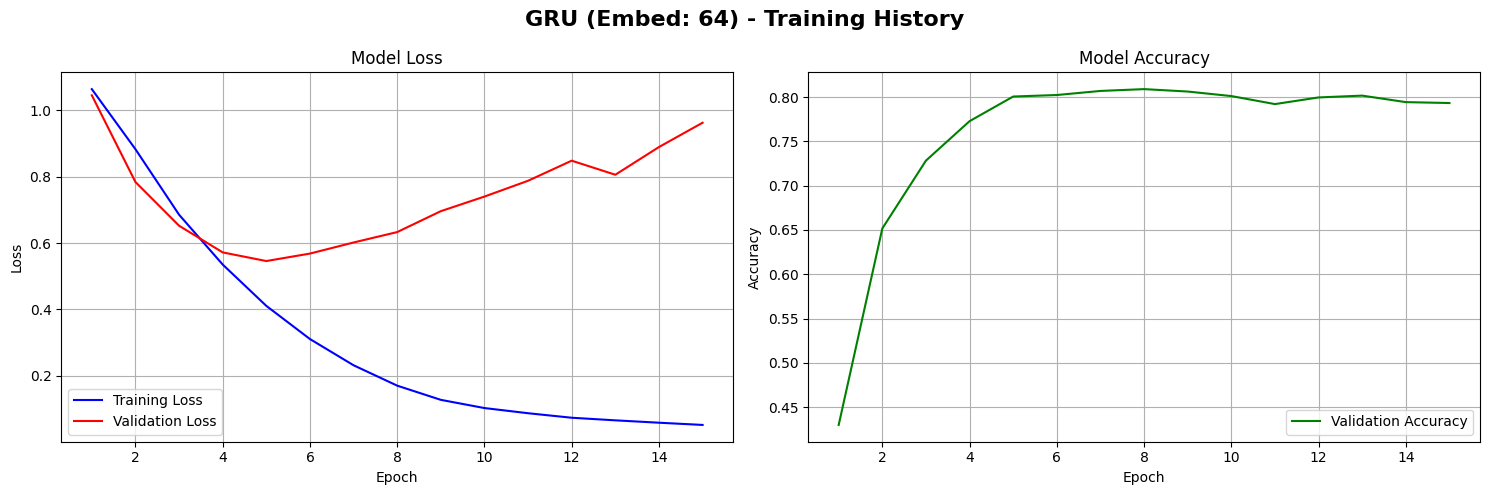

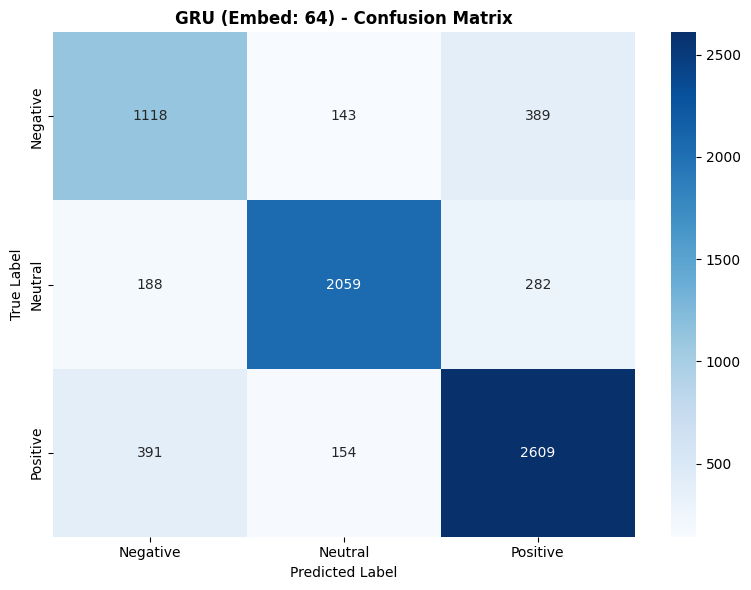

✓ Experiment completed successfully!
  Accuracy: 0.7890
  Balanced Accuracy: 0.7730
  F1-Score (Macro): 0.7740

EXPERIMENT 5/9
RNN Type: GRU | Embedding Dim: 128
--------------------------------------------------
Model created with 2019459 parameters
Training...
Epoch 1/15
  Train Loss: 1.0632
  Val Loss: 1.0609
  Val Accuracy: 0.4303
Epoch 2/15
  Train Loss: 0.9487
  Val Loss: 0.7768
  Val Accuracy: 0.6585
Epoch 3/15
  Train Loss: 0.6626
  Val Loss: 0.5961
  Val Accuracy: 0.7600
Epoch 4/15
  Train Loss: 0.4694
  Val Loss: 0.5247
  Val Accuracy: 0.8045
Epoch 5/15
  Train Loss: 0.3224
  Val Loss: 0.5023
  Val Accuracy: 0.8167
Epoch 6/15
  Train Loss: 0.2152
  Val Loss: 0.5561
  Val Accuracy: 0.8115
Epoch 7/15
  Train Loss: 0.1398
  Val Loss: 0.6372
  Val Accuracy: 0.8144
Epoch 8/15
  Train Loss: 0.0965
  Val Loss: 0.7516
  Val Accuracy: 0.8099
Epoch 9/15
  Train Loss: 0.0771
  Val Loss: 0.6726
  Val Accuracy: 0.8144
Epoch 10/15
  Train Loss: 0.0641
  Val Loss: 0.7929
  Val Accuracy: 0.8

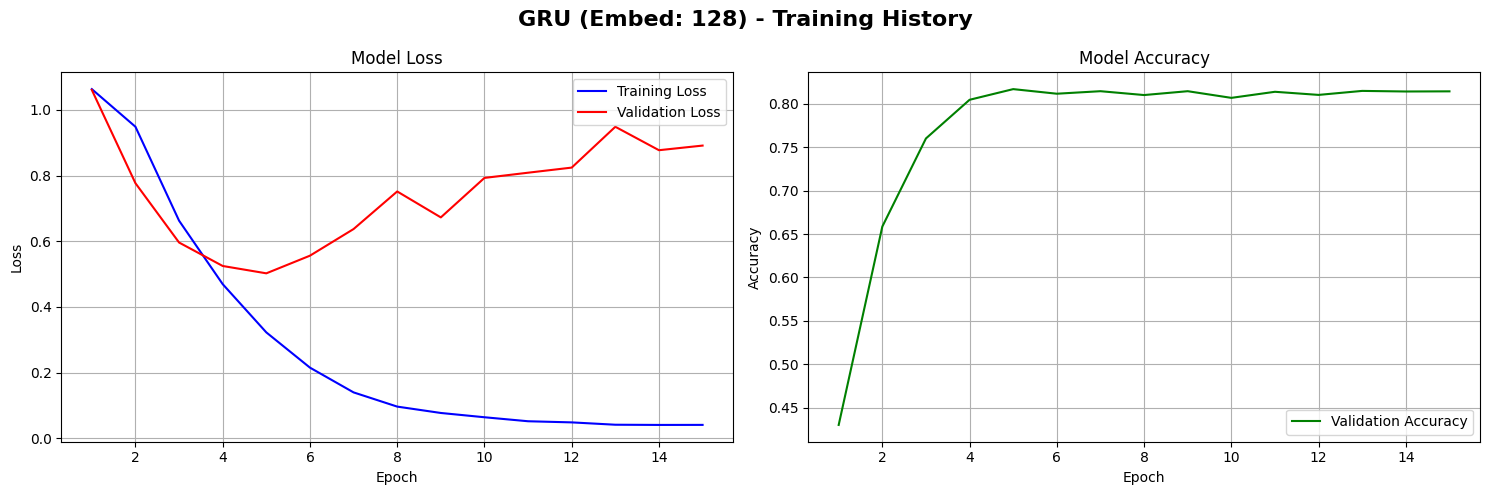

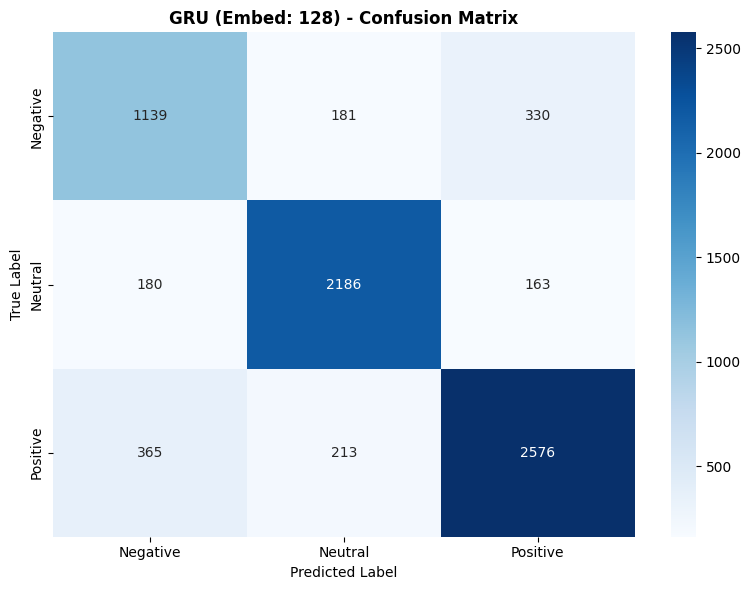

✓ Experiment completed successfully!
  Accuracy: 0.8047
  Balanced Accuracy: 0.7905
  F1-Score (Macro): 0.7890

EXPERIMENT 6/9
RNN Type: GRU | Embedding Dim: 256
--------------------------------------------------
Model created with 3988611 parameters
Training...
Epoch 1/15
  Train Loss: 1.0636
  Val Loss: 1.0613
  Val Accuracy: 0.4301
Epoch 2/15
  Train Loss: 0.9871
  Val Loss: 0.7969
  Val Accuracy: 0.6521
Epoch 3/15
  Train Loss: 0.6575
  Val Loss: 0.5799
  Val Accuracy: 0.7767
Epoch 4/15
  Train Loss: 0.4309
  Val Loss: 0.5170
  Val Accuracy: 0.8050
Epoch 5/15
  Train Loss: 0.2795
  Val Loss: 0.5587
  Val Accuracy: 0.8101
Epoch 6/15
  Train Loss: 0.1813
  Val Loss: 0.6456
  Val Accuracy: 0.8077
Epoch 7/15
  Train Loss: 0.1320
  Val Loss: 0.7095
  Val Accuracy: 0.8065
Epoch 8/15
  Train Loss: 0.1066
  Val Loss: 0.7190
  Val Accuracy: 0.8057
Epoch 9/15
  Train Loss: 0.0914
  Val Loss: 0.8304
  Val Accuracy: 0.8041
Epoch 10/15
  Train Loss: 0.0860
  Val Loss: 0.7773
  Val Accuracy: 0.8

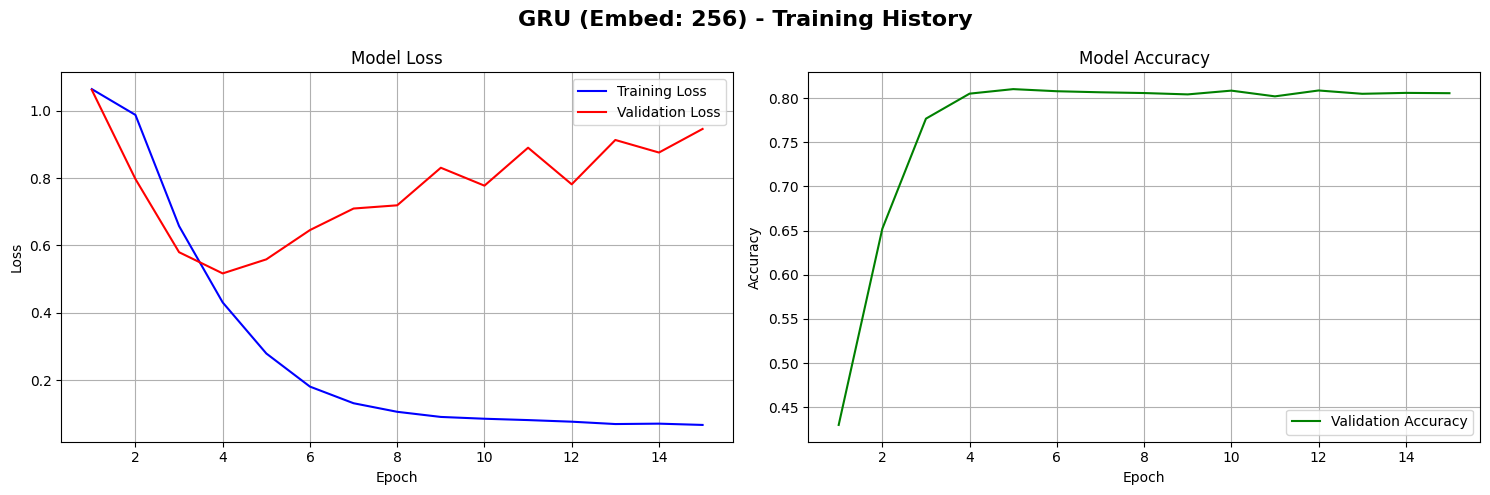

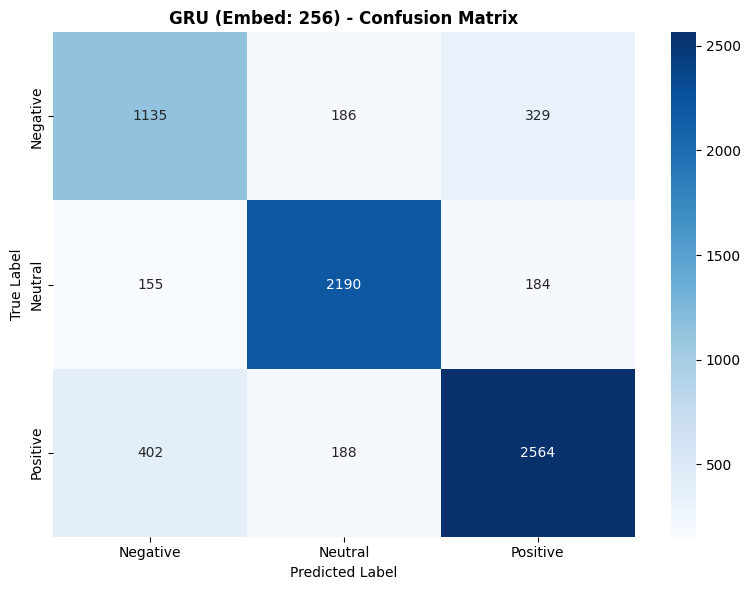

✓ Experiment completed successfully!
  Accuracy: 0.8031
  Balanced Accuracy: 0.7889
  F1-Score (Macro): 0.7874

EXPERIMENT 7/9
RNN Type: LSTM | Embedding Dim: 64
--------------------------------------------------
Model created with 1059715 parameters
Training...
Epoch 1/15
  Train Loss: 1.0650
  Val Loss: 1.0730
  Val Accuracy: 0.4301
Epoch 2/15
  Train Loss: 1.0579
  Val Loss: 1.0598
  Val Accuracy: 0.4301
Epoch 3/15
  Train Loss: 0.9975
  Val Loss: 0.9113
  Val Accuracy: 0.5844
Epoch 4/15
  Train Loss: 0.8973
  Val Loss: 0.8367
  Val Accuracy: 0.6309
Epoch 5/15
  Train Loss: 0.8077
  Val Loss: 0.7786
  Val Accuracy: 0.6614
Epoch 6/15
  Train Loss: 0.6913
  Val Loss: 0.7090
  Val Accuracy: 0.7080
Epoch 7/15
  Train Loss: 0.6096
  Val Loss: 0.6927
  Val Accuracy: 0.7289
Epoch 8/15
  Train Loss: 0.5534
  Val Loss: 0.6640
  Val Accuracy: 0.7472
Epoch 9/15
  Train Loss: 0.4839
  Val Loss: 0.6292
  Val Accuracy: 0.7571
Epoch 10/15
  Train Loss: 0.4235
  Val Loss: 0.6551
  Val Accuracy: 0.7

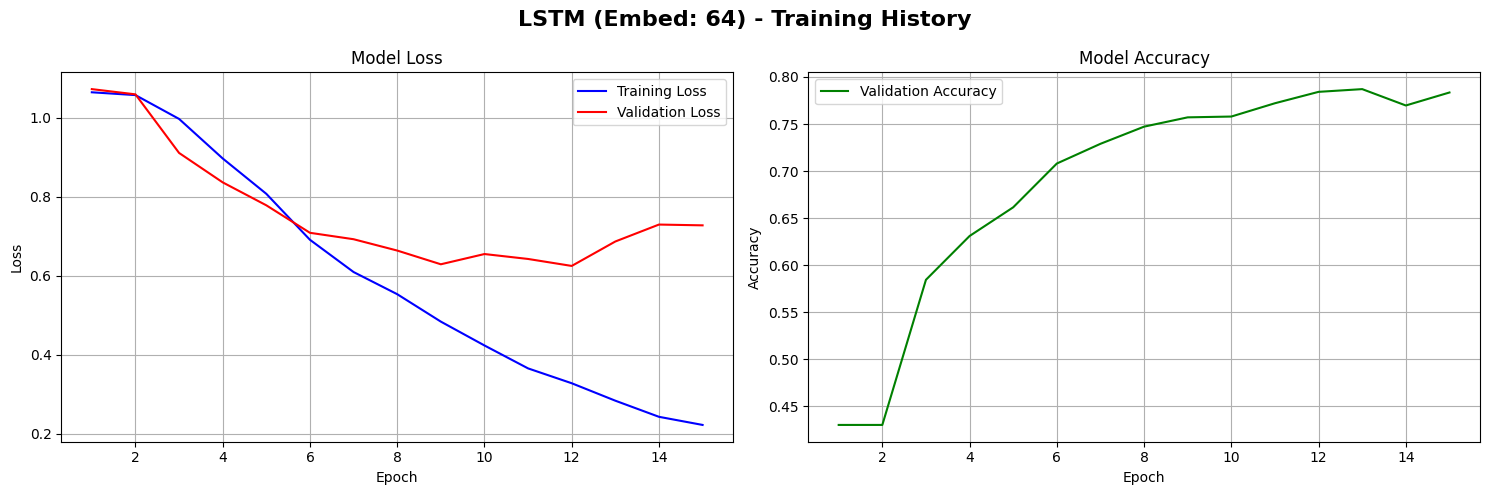

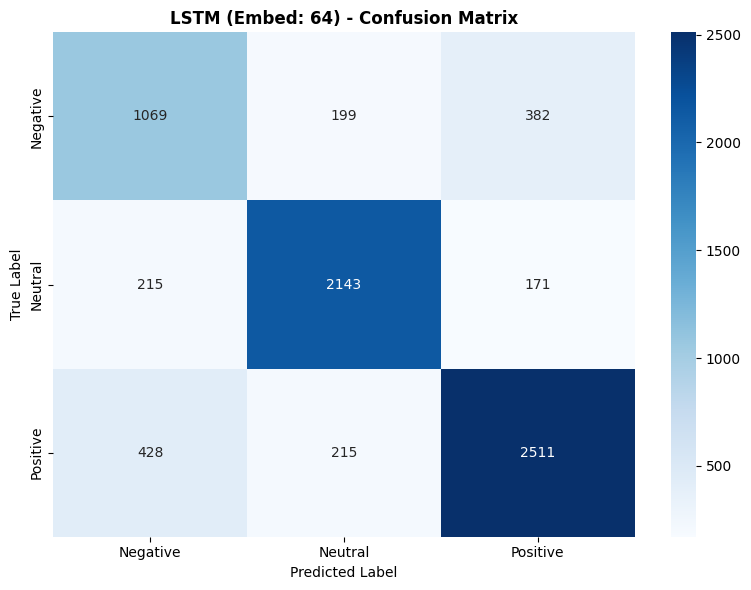

✓ Experiment completed successfully!
  Accuracy: 0.7804
  Balanced Accuracy: 0.7638
  F1-Score (Macro): 0.7621

EXPERIMENT 8/9
RNN Type: LSTM | Embedding Dim: 128
--------------------------------------------------
Model created with 2052483 parameters
Training...
Epoch 1/15
  Train Loss: 1.0671
  Val Loss: 1.0634
  Val Accuracy: 0.4296
Epoch 2/15
  Train Loss: 1.0636
  Val Loss: 1.0617
  Val Accuracy: 0.4298
Epoch 3/15
  Train Loss: 1.0451
  Val Loss: 0.9474
  Val Accuracy: 0.5915
Epoch 4/15
  Train Loss: 0.8971
  Val Loss: 0.8347
  Val Accuracy: 0.6301
Epoch 5/15
  Train Loss: 0.7498
  Val Loss: 0.7022
  Val Accuracy: 0.6925
Epoch 6/15
  Train Loss: 0.5610
  Val Loss: 0.5852
  Val Accuracy: 0.7695
Epoch 7/15
  Train Loss: 0.4241
  Val Loss: 0.5616
  Val Accuracy: 0.7941
Epoch 8/15
  Train Loss: 0.3181
  Val Loss: 0.5439
  Val Accuracy: 0.8004
Epoch 9/15
  Train Loss: 0.2378
  Val Loss: 0.6013
  Val Accuracy: 0.8074
Epoch 10/15
  Train Loss: 0.1790
  Val Loss: 0.6434
  Val Accuracy: 0.

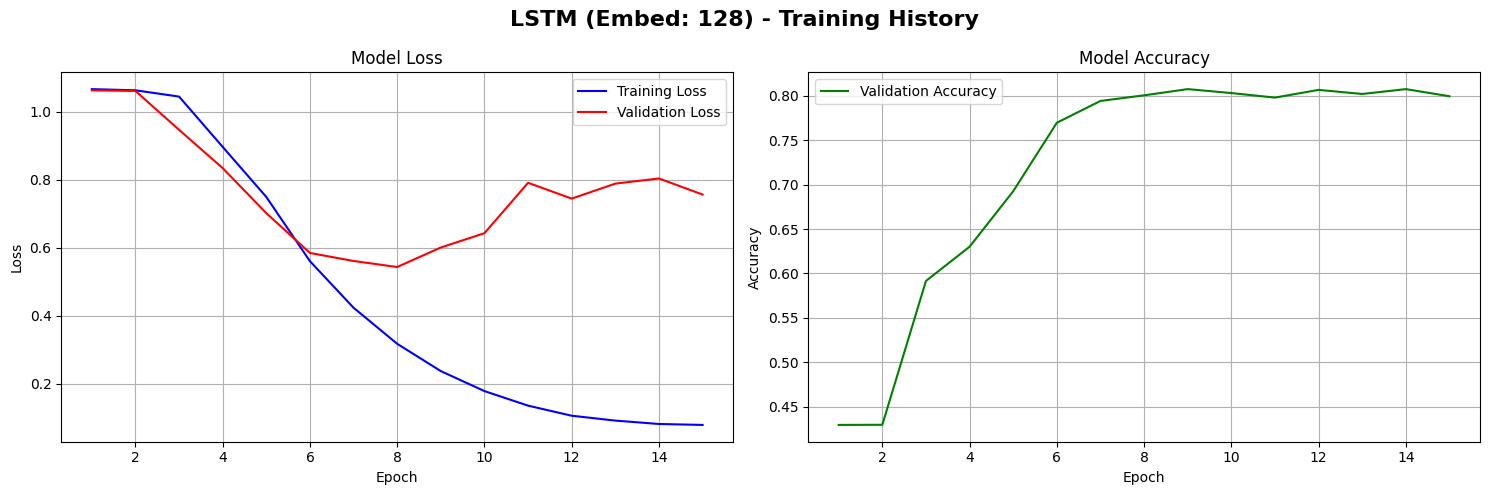

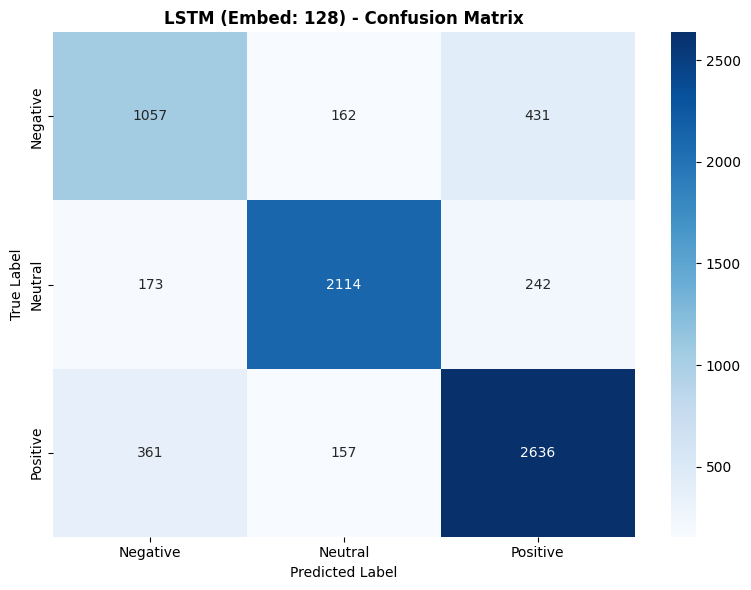

✓ Experiment completed successfully!
  Accuracy: 0.7919
  Balanced Accuracy: 0.7708
  F1-Score (Macro): 0.7734

EXPERIMENT 9/9
RNN Type: LSTM | Embedding Dim: 256
--------------------------------------------------
Model created with 4038019 parameters
Training...
Epoch 1/15
  Train Loss: 1.0648
  Val Loss: 1.0621
  Val Accuracy: 0.4299
Epoch 2/15
  Train Loss: 1.0545
  Val Loss: 1.0638
  Val Accuracy: 0.4289
Epoch 3/15
  Train Loss: 1.0484
  Val Loss: 1.0628
  Val Accuracy: 0.4296
Epoch 4/15
  Train Loss: 1.0350
  Val Loss: 0.9418
  Val Accuracy: 0.5939
Epoch 5/15
  Train Loss: 0.8340
  Val Loss: 0.7062
  Val Accuracy: 0.6882
Epoch 6/15
  Train Loss: 0.5941
  Val Loss: 0.5953
  Val Accuracy: 0.7654
Epoch 7/15
  Train Loss: 0.4337
  Val Loss: 0.5627
  Val Accuracy: 0.7857
Epoch 8/15
  Train Loss: 0.3092
  Val Loss: 0.5509
  Val Accuracy: 0.8026
Epoch 9/15
  Train Loss: 0.2168
  Val Loss: 0.6031
  Val Accuracy: 0.8079
Epoch 10/15
  Train Loss: 0.1609
  Val Loss: 0.6755
  Val Accuracy: 0.

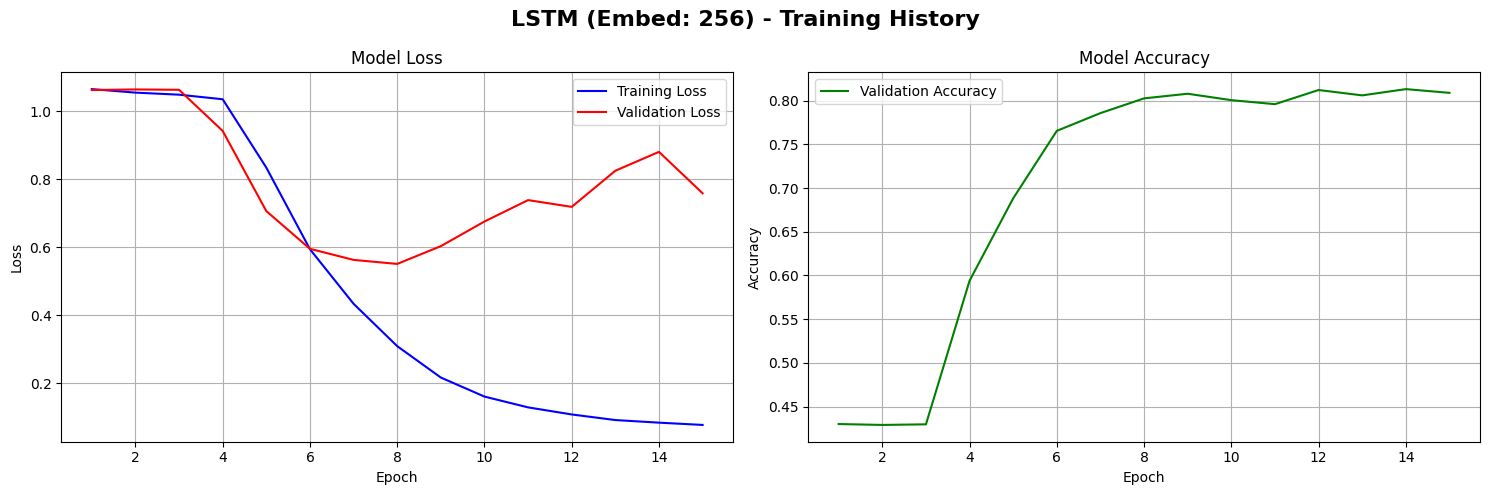

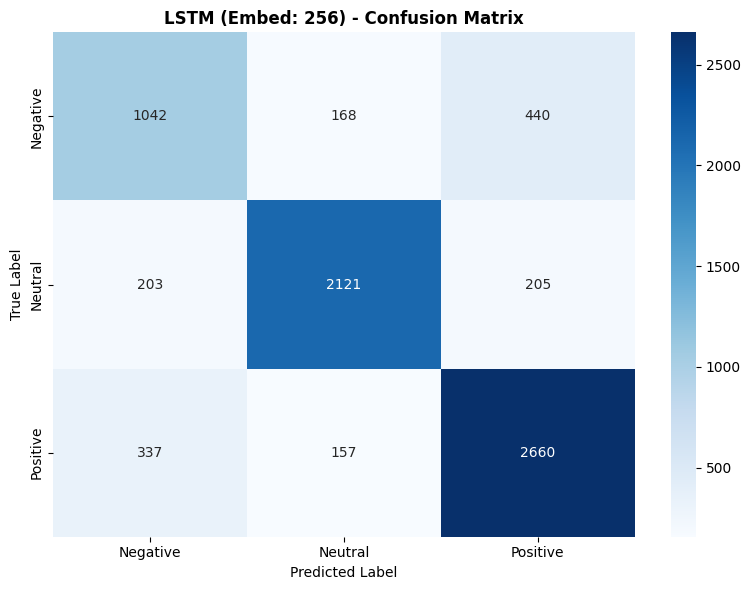

✓ Experiment completed successfully!
  Accuracy: 0.7941
  Balanced Accuracy: 0.7712
  F1-Score (Macro): 0.7737

ALL EXPERIMENTS COMPLETED


In [21]:
# Run experiments
experiment_results = []
all_eval_results = []

total_experiments = len(rnn_types) * len(embed_dims)
experiment_counter = 0

print(f"\nStarting {total_experiments} experiments...")
print("="*80)

for rnn_type in rnn_types:
    for embed_dim in embed_dims:
        experiment_counter += 1

        print(f"\nEXPERIMENT {experiment_counter}/{total_experiments}")
        print(f"RNN Type: {rnn_type} | Embedding Dim: {embed_dim}")
        print("-" * 50)

        with mlflow.start_run() as run:
            try:
                # Set run metadata
                run_name = f"{rnn_type}_embed{embed_dim}"
                mlflow.set_tag("mlflow.runName", run_name)
                mlflow.set_tag("rnn_type", rnn_type)
                mlflow.set_tag("embed_dim", embed_dim)

                # Log parameters
                mlflow.log_param("rnn_type", rnn_type)
                mlflow.log_param("embed_dim", embed_dim)
                mlflow.log_param("hidden_dim", hidden_dim)
                mlflow.log_param("vocab_size", len(vocab))
                mlflow.log_param("max_seq_length", max_seq_length)
                mlflow.log_param("batch_size", batch_size)
                mlflow.log_param("num_epochs", num_epochs)
                mlflow.log_param("learning_rate", learning_rate)
                mlflow.log_param("train_size", len(X_train))
                mlflow.log_param("val_size", len(X_val))
                mlflow.log_param("test_size", len(X_test))

                # Create and train model
                model = SentimentRNN(
                    vocab_size=len(vocab),
                    embed_dim=embed_dim,
                    hidden_dim=hidden_dim,
                    num_classes=num_classes,
                    rnn_type=rnn_type
                ).to(device)

                print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")

                # Train model
                print("Training...")
                history = train_model(model, train_loader, val_loader, num_epochs, learning_rate)

                # Evaluate model
                print("Evaluating...")
                eval_results = evaluate_model(model, test_loader)

                # Log metrics to MLflow
                mlflow.log_metric("accuracy", eval_results['accuracy'])
                mlflow.log_metric("balanced_accuracy", eval_results['balanced_accuracy'])
                mlflow.log_metric("f1_macro", eval_results['f1_macro'])
                mlflow.log_metric("f1_weighted", eval_results['f1_weighted'])
                mlflow.log_metric("matthews_corrcoef", eval_results['matthews_corrcoef'])
                mlflow.log_metric("cohen_kappa", eval_results['cohen_kappa'])
                mlflow.log_metric("best_val_loss", history['best_val_loss'])

                # Log per-class metrics
                class_names = ['Negative', 'Neutral', 'Positive']
                for i, class_name in enumerate(class_names):
                    mlflow.log_metric(f"{class_name}_precision", eval_results['precision_per_class'][i])
                    mlflow.log_metric(f"{class_name}_recall", eval_results['recall_per_class'][i])
                    mlflow.log_metric(f"{class_name}_f1", eval_results['f1_per_class'][i])

                # Create and save visualizations
                # Training history plot
                history_fig = plot_training_history(history, f"{rnn_type} (Embed: {embed_dim}) - Training History")
                history_filename = f"training_history_{rnn_type}_{embed_dim}.png"
                history_fig.savefig(history_filename, dpi=300, bbox_inches='tight')
                mlflow.log_artifact(history_filename)
                plt.show()

                # Confusion matrix plot
                conf_fig = plot_confusion_matrix(
                    eval_results['confusion_matrix'],
                    class_names,
                    f"{rnn_type} (Embed: {embed_dim}) - Confusion Matrix"
                )
                conf_filename = f"confusion_matrix_{rnn_type}_{embed_dim}.png"
                conf_fig.savefig(conf_filename, dpi=300, bbox_inches='tight')
                mlflow.log_artifact(conf_filename)
                plt.show()

                # Save model
                model_filename = f"model_{rnn_type}_{embed_dim}.pth"
                torch.save(model.state_dict(), model_filename)
                mlflow.log_artifact(model_filename)

                # Store results
                result = {
                    'run_id': run.info.run_id,
                    'rnn_type': rnn_type,
                    'embed_dim': embed_dim,
                    'accuracy': eval_results['accuracy'],
                    'balanced_accuracy': eval_results['balanced_accuracy'],
                    'f1_macro': eval_results['f1_macro'],
                    'f1_weighted': eval_results['f1_weighted'],
                    'matthews_corrcoef': eval_results['matthews_corrcoef'],
                    'cohen_kappa': eval_results['cohen_kappa'],
                    'best_val_loss': history['best_val_loss']
                }

                experiment_results.append(result)
                all_eval_results.append(eval_results)

                print(f"✓ Experiment completed successfully!")
                print(f"  Accuracy: {eval_results['accuracy']:.4f}")
                print(f"  Balanced Accuracy: {eval_results['balanced_accuracy']:.4f}")
                print(f"  F1-Score (Macro): {eval_results['f1_macro']:.4f}")

            except Exception as e:
                print(f"✗ Experiment failed: {e}")
                continue

print("\n" + "="*80)
print("ALL EXPERIMENTS COMPLETED")
print("="*80)

# 5. Results Analysis and Comparison


Successful experiments: 9/9

Best Configuration:
  RNN Type: GRU
  Embedding Dim: 128
  Accuracy: 0.8047
  Balanced Accuracy: 0.7905
  F1-Score (Macro): 0.7890
  Matthews Correlation: 0.6983

All Results (sorted by Balanced Accuracy):
rnn_type  embed_dim  accuracy  balanced_accuracy  f1_macro  matthews_corrcoef
     GRU        128    0.8047             0.7905    0.7890             0.6983
     GRU        256    0.8031             0.7889    0.7874             0.6957
     GRU         64    0.7890             0.7730    0.7740             0.6733
    LSTM        256    0.7941             0.7712    0.7737             0.6799
    LSTM        128    0.7919             0.7708    0.7734             0.6766
    LSTM         64    0.7804             0.7638    0.7621             0.6610
     RNN         64    0.4204             0.3323    0.2448            -0.0021
     RNN        128    0.4274             0.3314    0.2004            -0.0315
     RNN        256    0.4237             0.3296    0.2033    

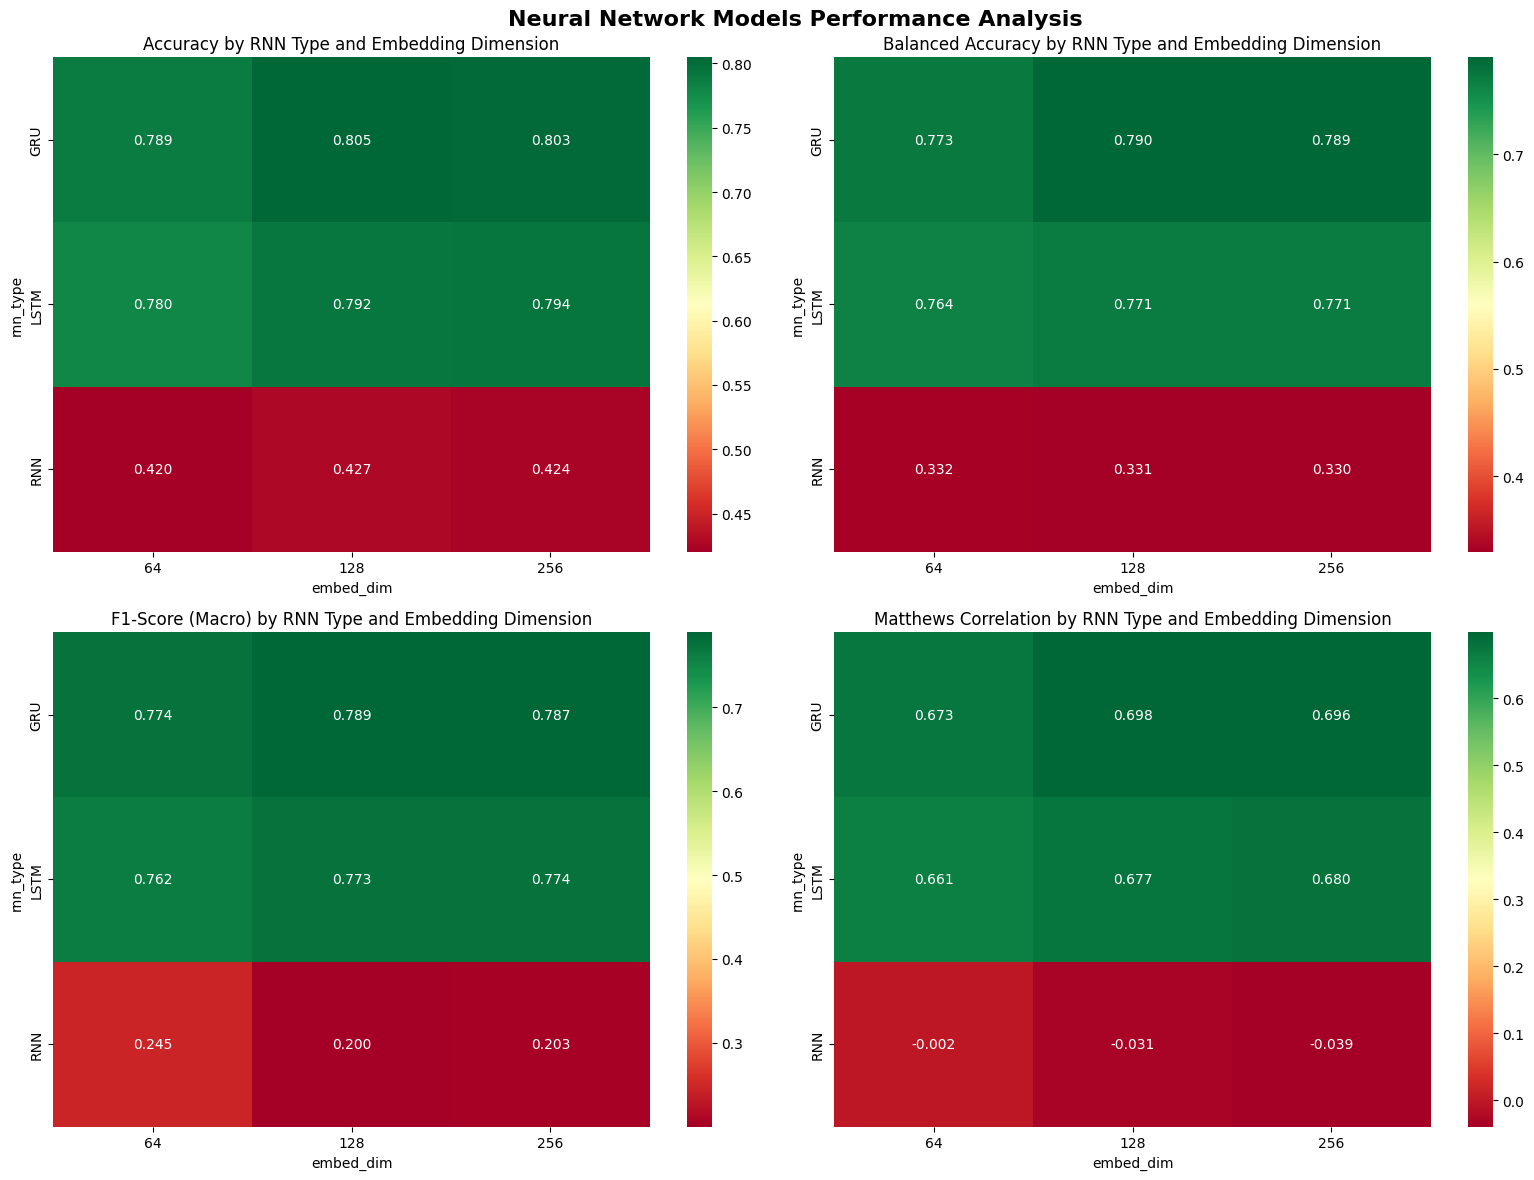

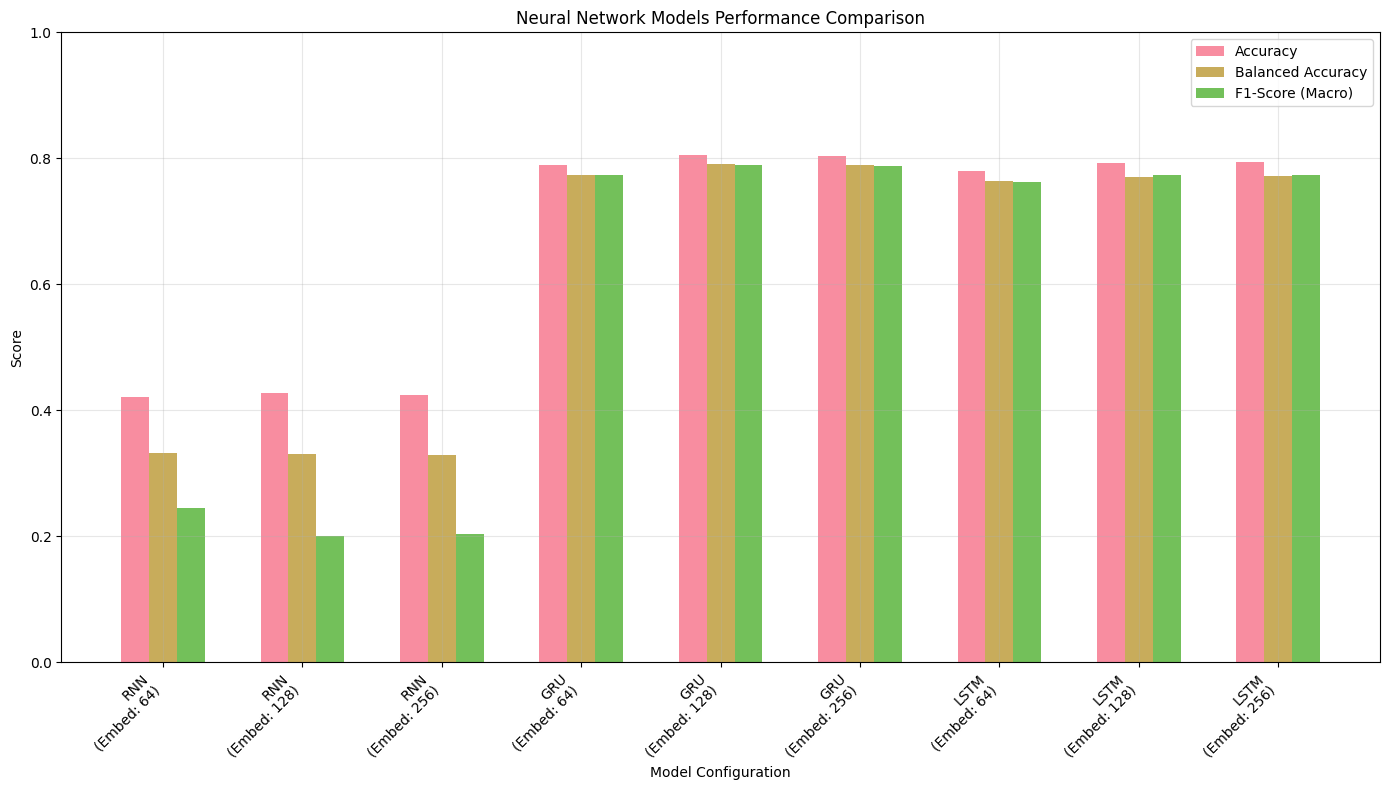


Performance Analysis by RNN Type:
         accuracy                 balanced_accuracy                 f1_macro  \
             mean     std     max              mean     std     max     mean   
rnn_type                                                                       
GRU        0.7989  0.0086  0.8047            0.7841  0.0097  0.7905   0.7835   
LSTM       0.7888  0.0073  0.7941            0.7686  0.0042  0.7712   0.7697   
RNN        0.4238  0.0035  0.4274            0.3311  0.0014  0.3323   0.2162   

                          
             std     max  
rnn_type                  
GRU       0.0082  0.7890  
LSTM      0.0066  0.7737  
RNN       0.0248  0.2448  

Performance Analysis by Embedding Dimension:
          accuracy                 balanced_accuracy                 f1_macro  \
              mean     std     max              mean     std     max     mean   
embed_dim                                                                       
64          0.6633  0.2104  0.789

In [22]:
if experiment_results:
    # Convert to DataFrame
    results_df = pd.DataFrame(experiment_results)

    # Save results
    results_df.to_csv("neural_network_experiment_results.csv", index=False)

    print(f"\nSuccessful experiments: {len(experiment_results)}/{total_experiments}")

    # Find best configuration
    best_idx = results_df['balanced_accuracy'].idxmax()
    best_config = results_df.loc[best_idx]

    print(f"\nBest Configuration:")
    print(f"  RNN Type: {best_config['rnn_type']}")
    print(f"  Embedding Dim: {best_config['embed_dim']}")
    print(f"  Accuracy: {best_config['accuracy']:.4f}")
    print(f"  Balanced Accuracy: {best_config['balanced_accuracy']:.4f}")
    print(f"  F1-Score (Macro): {best_config['f1_macro']:.4f}")
    print(f"  Matthews Correlation: {best_config['matthews_corrcoef']:.4f}")

    # Display all results
    print(f"\nAll Results (sorted by Balanced Accuracy):")
    display_cols = ['rnn_type', 'embed_dim', 'accuracy', 'balanced_accuracy', 'f1_macro', 'matthews_corrcoef']
    sorted_results = results_df.sort_values('balanced_accuracy', ascending=False)[display_cols]
    print(sorted_results.to_string(index=False, float_format='%.4f'))

    # Create comprehensive comparison visualizations

    # 1. Heatmap of performance by RNN type and embedding dimension
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Neural Network Models Performance Analysis', fontsize=16, fontweight='bold')

    # Accuracy heatmap
    pivot_acc = results_df.pivot_table(values='accuracy', index='rnn_type', columns='embed_dim')
    sns.heatmap(pivot_acc, annot=True, fmt='.3f', cmap='RdYlGn', ax=axes[0,0])
    axes[0,0].set_title('Accuracy by RNN Type and Embedding Dimension')

    # Balanced accuracy heatmap
    pivot_bal_acc = results_df.pivot_table(values='balanced_accuracy', index='rnn_type', columns='embed_dim')
    sns.heatmap(pivot_bal_acc, annot=True, fmt='.3f', cmap='RdYlGn', ax=axes[0,1])
    axes[0,1].set_title('Balanced Accuracy by RNN Type and Embedding Dimension')

    # F1 macro heatmap
    pivot_f1 = results_df.pivot_table(values='f1_macro', index='rnn_type', columns='embed_dim')
    sns.heatmap(pivot_f1, annot=True, fmt='.3f', cmap='RdYlGn', ax=axes[1,0])
    axes[1,0].set_title('F1-Score (Macro) by RNN Type and Embedding Dimension')

    # Matthews correlation heatmap
    pivot_mcc = results_df.pivot_table(values='matthews_corrcoef', index='rnn_type', columns='embed_dim')
    sns.heatmap(pivot_mcc, annot=True, fmt='.3f', cmap='RdYlGn', ax=axes[1,1])
    axes[1,1].set_title('Matthews Correlation by RNN Type and Embedding Dimension')

    plt.tight_layout()
    plt.savefig("comprehensive_nn_analysis.png", dpi=300, bbox_inches='tight')
    plt.show()

    # 2. Bar plot comparison
    fig, ax = plt.subplots(figsize=(14, 8))

    x_labels = [f"{row['rnn_type']}\n(Embed: {row['embed_dim']})" for _, row in results_df.iterrows()]
    x_pos = np.arange(len(x_labels))

    width = 0.2
    ax.bar(x_pos - width, results_df['accuracy'], width, label='Accuracy', alpha=0.8)
    ax.bar(x_pos, results_df['balanced_accuracy'], width, label='Balanced Accuracy', alpha=0.8)
    ax.bar(x_pos + width, results_df['f1_macro'], width, label='F1-Score (Macro)', alpha=0.8)

    ax.set_xlabel('Model Configuration')
    ax.set_ylabel('Score')
    ax.set_title('Neural Network Models Performance Comparison')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x_labels, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1)

    plt.tight_layout()
    plt.savefig("nn_models_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

    # 3. Analysis by RNN type
    print(f"\nPerformance Analysis by RNN Type:")
    rnn_analysis = results_df.groupby('rnn_type').agg({
        'accuracy': ['mean', 'std', 'max'],
        'balanced_accuracy': ['mean', 'std', 'max'],
        'f1_macro': ['mean', 'std', 'max']
    }).round(4)
    print(rnn_analysis)

    # 4. Analysis by embedding dimension
    print(f"\nPerformance Analysis by Embedding Dimension:")
    embed_analysis = results_df.groupby('embed_dim').agg({
        'accuracy': ['mean', 'std', 'max'],
        'balanced_accuracy': ['mean', 'std', 'max'],
        'f1_macro': ['mean', 'std', 'max']
    }).round(4)
    print(embed_analysis)

    # Log summary to MLflow
    with mlflow.start_run() as summary_run:
        mlflow.set_tag("mlflow.runName", "Neural_Network_Experiment_Summary")
        mlflow.set_tag("experiment_type", "summary")

        # Log best configuration metrics
        mlflow.log_metric("best_accuracy", best_config['accuracy'])
        mlflow.log_metric("best_balanced_accuracy", best_config['balanced_accuracy'])
        mlflow.log_metric("best_f1_macro", best_config['f1_macro'])
        mlflow.log_metric("best_matthews_corrcoef", best_config['matthews_corrcoef'])

        # Log best configuration parameters
        mlflow.log_param("best_rnn_type", best_config['rnn_type'])
        mlflow.log_param("best_embed_dim", best_config['embed_dim'])
        mlflow.log_param("total_experiments", total_experiments)
        mlflow.log_param("successful_experiments", len(experiment_results))

        # Log summary artifacts
        mlflow.log_artifact("neural_network_experiment_results.csv")
        mlflow.log_artifact("comprehensive_nn_analysis.png")
        mlflow.log_artifact("nn_models_comparison.png")

    print(f"\n🎉 Neural Network Experiment Completed Successfully!")
    print(f"✓ Best model: {best_config['rnn_type']} with {best_config['embed_dim']}-dim embeddings")
    print(f"✓ Best balanced accuracy: {best_config['balanced_accuracy']:.4f}")
    print(f"✓ All results logged to MLflow")

else:
    print("No successful experiments to analyze.")

# Final Summary

In [23]:
print(f"\n{'='*80}")
print("NEURAL NETWORK EXPERIMENT SUMMARY")
print(f"{'='*80}")

if experiment_results:
    print(f"\nEXPERIMENT STATISTICS:")
    print(f"   • Total experiments: {total_experiments}")
    print(f"   • Successful experiments: {len(experiment_results)}")
    print(f"   • RNN types tested: {len(rnn_types)} (RNN, GRU, LSTM)")
    print(f"   • Embedding dimensions tested: {len(embed_dims)} (64, 128, 256)")

    print(f"\nBEST PERFORMING MODEL:")
    print(f"   • Architecture: {best_config['rnn_type']}")
    print(f"   • Embedding Dimension: {best_config['embed_dim']}")
    print(f"   • Accuracy: {best_config['accuracy']:.4f}")
    print(f"   • Balanced Accuracy: {best_config['balanced_accuracy']:.4f}")
    print(f"   • F1-Score (Macro): {best_config['f1_macro']:.4f}")
    print(f"   • Matthews Correlation: {best_config['matthews_corrcoef']:.4f}")

    print(f"\nKEY INSIGHTS:")

    # Best RNN type
    best_rnn_type = results_df.groupby('rnn_type')['balanced_accuracy'].mean().idxmax()
    best_rnn_score = results_df.groupby('rnn_type')['balanced_accuracy'].mean().max()
    print(f"   • Best RNN Type: {best_rnn_type} (avg: {best_rnn_score:.4f})")

    # Best embedding dimension
    best_embed_dim = results_df.groupby('embed_dim')['balanced_accuracy'].mean().idxmax()
    best_embed_score = results_df.groupby('embed_dim')['balanced_accuracy'].mean().max()
    print(f"   • Best Embedding Dimension: {best_embed_dim} (avg: {best_embed_score:.4f})")

    # Performance range
    min_performance = results_df['balanced_accuracy'].min()
    max_performance = results_df['balanced_accuracy'].max()
    print(f"   • Performance Range: {min_performance:.4f} - {max_performance:.4f}")

    print(f"\nMODEL CONFIGURATION:")
    print(f"   • Vocabulary Size: {len(vocab):,}")
    print(f"   • Max Sequence Length: {max_seq_length}")
    print(f"   • Hidden Dimension: {hidden_dim}")
    print(f"   • Batch Size: {batch_size}")
    print(f"   • Training Epochs: {num_epochs}")
    print(f"   • Learning Rate: {learning_rate}")

    print(f"\nOUTPUT FILES:")
    output_files = [
        "neural_network_experiment_results.csv",
        "comprehensive_nn_analysis.png",
        "nn_models_comparison.png",
        f"model_{best_config['rnn_type']}_{best_config['embed_dim']}.pth"
    ]

    for file in output_files:
        print(f"   • {file}")

    print(f"\nRECOMMENDATIONS:")
    print(f"   1. Use {best_config['rnn_type']} architecture for production")
    print(f"   2. Set embedding dimension to {best_config['embed_dim']}")
    print(f"   3. Consider ensemble methods combining top-performing models")
    print(f"   4. Fine-tune hyperparameters for the best architecture")
    print(f"   5. Experiment with pre-trained embeddings (Word2Vec, GloVe)")

    # Compare with previous experiments (if available)
    print(f"\nCOMPARISON WITH PREVIOUS EXPERIMENTS:")
    try:
        # Try to load previous results
        previous_results = pd.read_csv("enhanced_experiment_results.csv")
        best_previous = previous_results['balanced_accuracy'].max()

        improvement = best_config['balanced_accuracy'] - best_previous
        improvement_pct = (improvement / best_previous) * 100

        print(f"   • Previous Best (Traditional ML): {best_previous:.4f}")
        print(f"   • Current Best (Neural Networks): {best_config['balanced_accuracy']:.4f}")

        if improvement > 0:
            print(f"   • Improvement: +{improvement:.4f} ({improvement_pct:+.1f}%)")
            print(f"   • Neural networks outperformed traditional ML methods!")
        else:
            print(f"   • Difference: {improvement:.4f} ({improvement_pct:.1f}%)")
            print(f"   • Traditional ML methods performed better")

    except FileNotFoundError:
        print(f"   • Previous experiment results not found")
        print(f"   • This is the first neural network experiment")

else:
    print(f"\nNO SUCCESSFUL EXPERIMENTS")
    print(f"   • Please check the data and model configurations")
    print(f"   • Verify GPU/CPU compatibility")
    print(f"   • Check memory requirements")

print(f"\nNEXT STEPS:")
print(f"   1. Fine-tune the best performing model")
print(f"   2. Experiment with pre-trained embeddings")
print(f"   3. Try more advanced architectures (Attention, Transformers)")
print(f"   4. Implement early stopping and learning rate scheduling")
print(f"   5. Consider data augmentation techniques")

print(f"\n{'='*80}")
print("END OF NEURAL NETWORK EXPERIMENT")
print(f"{'='*80}")

# Optional: Create a simple prediction function for the best model
if experiment_results:
    print(f"\nSAMPLE PREDICTIONS WITH BEST MODEL:")

    # Load the best model
    try:
        best_model = SentimentRNN(
            vocab_size=len(vocab),
            embed_dim=best_config['embed_dim'],
            hidden_dim=hidden_dim,
            num_classes=num_classes,
            rnn_type=best_config['rnn_type']
        ).to(device)

        best_model.load_state_dict(torch.load(f"model_{best_config['rnn_type']}_{best_config['embed_dim']}.pth"))
        best_model.eval()

        def predict_sentiment(text):
            """Predict sentiment for a single text"""
            indices = text_to_indices(text, vocab, max_seq_length)
            input_tensor = torch.tensor([indices], dtype=torch.long).to(device)

            with torch.no_grad():
                output = best_model(input_tensor)
                probabilities = torch.softmax(output, dim=1)
                predicted_class = torch.argmax(output, dim=1).item()

            # Convert back to original labels
            reverse_mapping = {0: -1, 1: 0, 2: 1}  # 0->Negative, 1->Neutral, 2->Positive
            original_label = reverse_mapping[predicted_class]

            class_names = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}
            sentiment = class_names[original_label]
            confidence = probabilities[0][predicted_class].item()

            return sentiment, confidence, probabilities[0].cpu().numpy()

        # Test with sample texts
        sample_texts = [
            "I love this movie, it's amazing!",
            "This is terrible, I hate it",
            "It's okay, nothing special",
            "Best day ever! So happy!",
            "I'm feeling sad today"
        ]

        print(f"\n   Sample predictions:")
        for text in sample_texts:
            sentiment, confidence, probs = predict_sentiment(text)
            print(f"   Text: '{text}'")
            print(f"   Prediction: {sentiment} (confidence: {confidence:.3f})")
            print(f"   Probabilities: Neg={probs[0]:.3f}, Neu={probs[1]:.3f}, Pos={probs[2]:.3f}")
            print()

    except Exception as e:
        print(f"   Could not load best model for predictions: {e}")


NEURAL NETWORK EXPERIMENT SUMMARY

EXPERIMENT STATISTICS:
   • Total experiments: 9
   • Successful experiments: 9
   • RNN types tested: 3 (RNN, GRU, LSTM)
   • Embedding dimensions tested: 3 (64, 128, 256)

BEST PERFORMING MODEL:
   • Architecture: GRU
   • Embedding Dimension: 128
   • Accuracy: 0.8047
   • Balanced Accuracy: 0.7905
   • F1-Score (Macro): 0.7890
   • Matthews Correlation: 0.6983

KEY INSIGHTS:
   • Best RNN Type: GRU (avg: 0.7841)
   • Best Embedding Dimension: 128 (avg: 0.6309)
   • Performance Range: 0.3296 - 0.7905

MODEL CONFIGURATION:
   • Vocabulary Size: 15,000
   • Max Sequence Length: 128
   • Hidden Dimension: 128
   • Batch Size: 64
   • Training Epochs: 15
   • Learning Rate: 0.001

OUTPUT FILES:
   • neural_network_experiment_results.csv
   • comprehensive_nn_analysis.png
   • nn_models_comparison.png
   • model_GRU_128.pth

RECOMMENDATIONS:
   1. Use GRU architecture for production
   2. Set embedding dimension to 128
   3. Consider ensemble methods c

In [24]:
!pip install pyngrok

In [25]:
from google.colab import userdata
NGROK_AUTHTOKEN = userdata.get('NGROK_AUTHTOKEN')

In [26]:
!ngrok config add-authtoken NGROK_AUTHTOKEN

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [27]:
import subprocess
import threading
from pyngrok import ngrok

# Tracking URI
tracking_uri = "file:///content/drive/MyDrive/mlflow_logs"

def start_mlflow_ui():
    subprocess.run(["mlflow", "ui", "--backend-store-uri", tracking_uri, "--port", "5000"])

threading.Thread(target=start_mlflow_ui).start()

public_url = ngrok.connect(5000)
print(f"Open MLflow UI at: NgrokTunnel: {public_url}")

Open MLflow UI at: NgrokTunnel: NgrokTunnel: "https://1b9ad1860ba8.ngrok-free.app" -> "http://localhost:5000"



## **Neural Network Performance Summary – Round 4**

In this round, I trained and evaluated 9 RNN-based models using three architectures (RNN, GRU, LSTM) and three embedding dimensions (64, 128, 256). The goal was to improve performance, especially considering the previous imbalance in the dataset.

### Best Performing Model:

* **Architecture:** GRU
* **Embedding Dimension:** 128
* **Accuracy:** 80.47%
* **Balanced Accuracy:** 79.05%
* **Macro F1-Score:** 78.90%
* **Matthews Correlation Coefficient:** 0.698

This model showed strong, consistent results across all metrics and outperformed all others.

---

## **Improvements Compared to Previous Experiment (Logistic Regression + TF-IDF)**

| Metric            | Previous Best (TF-IDF + Logistic Regression) | Current Best (GRU + Embedding) |
| ----------------- | -------------------------------------------- | ------------------------------ |
| Accuracy          | 66.2%                                        | 80.47%                         |
| Balanced Accuracy | 66.2%                                        | 79.05%                         |
| Macro F1-Score    | 65.8%                                        | 78.90%                         |
| Negative F1-Score | 57.5%                                        | 68.3%                          |
| Neutral F1-Score  | 72%                                          | 85.6%                          |
| Positive F1-Score | 68%                                          | 82.8%                          |

Compared to the last experiment, this round achieved a noticeable improvement in all class-wise and overall metrics. The model also handled the **imbalanced data** much better, showing high recall and F1 scores across all sentiment categories.

---

## **Key Takeaways**

* GRU architecture performs significantly better than LSTM and basic RNNs for this task.
* Embedding dimension of 128 provided the best balance of performance and stability.
* The model now predicts all three classes (Negative, Neutral, Positive) more fairly.
* The previous issues with low recall on the Negative class have been largely addressed.

---

## **To further improve performance:**

1. Integrate pre-trained embeddings (e.g., Word2Vec, GloVe).
2. Try advanced architectures (e.g., Attention-based RNNs or Transformers).
3. Use learning rate scheduling and early stopping.
4. Explore ensemble approaches combining top-performing models.

